error connecting in 'pool-13': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
Multiple connection attempts failed. All failures were:
- host: 'localhost', port: '5432', hostaddr: '::1': connection failed: connection to server at "::1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
- host: 'localhost', port: '5432', hostaddr: '127.0.0.1': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
error connecting in 'pool-13': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
Multiple connection attempts failed. All failures were:
- host: 'localhost', port: '5432', hostaddr: '::1': connection failed: connection to server at "::1", port 5432 failed: could not receive data from server: Conn

STARTED


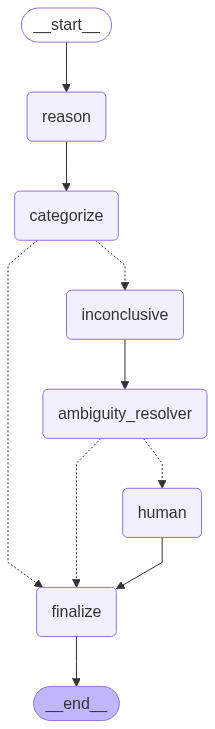

THREAD e5b91751-0bab-49a3-b75d-e347b04991dd


error connecting in 'pool-13': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
Multiple connection attempts failed. All failures were:
- host: 'localhost', port: '5432', hostaddr: '::1': connection failed: connection to server at "::1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
- host: 'localhost', port: '5432', hostaddr: '127.0.0.1': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
error connecting in 'pool-13': connection failed: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"
Multiple connection attempts failed. All failures were:
- host: 'localhost', port: '5432', hostaddr: '::1': connection failed: connection to server at "::1", port 5432 failed: could not receive data from server: Conn

PoolTimeout: couldn't get a connection after 30.00 sec

In [13]:
import json
import os
import uuid
from typing import Annotated, TypedDict, Any, Literal
from IPython.display import display, Image

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import interrupt, Command
from langgraph.checkpoint.postgres import PostgresSaver
from psycopg_pool import ConnectionPool

load_dotenv()
print("STARTED")


LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")

REASON_NODE_NAME = "reason"
CATEGORIZE_NODE_NAME = "categorize"
FINALIZE_NODE_NAME = "finalize"
INCONCLUSIVE_NODE_NAME = "inconclusive"
HUMAN_IN_THE_LOOP_NODE_NAME = "human"


llm = ChatOpenAI(model=LITE_MODEL, api_key=LITE_LLM_API_KEY, base_url=LITE_LLM_URL)


class State(TypedDict):
    messages: Annotated[list, add_messages]
    is_ambiguous: bool
    ambiguous_questions: Annotated[list, add_messages]


def reason(state: State) -> State:
    prompt_template = ChatPromptTemplate.from_template(
        """
    Check for the users spelling mistakes and validate whether the input is correct.
    Do not look at case sensitivity!
    Respond with json format corrected_spelling and corrections_applied (boolean) as fields!
    Input: {input}
    """
    )
    chain = prompt_template | llm
    chain_res = chain.invoke({"input": state["messages"][-1]})
    print("Reason", chain_res.content)
    content = chain_res.content.strip("```json").strip("```")
    json_content = json.loads(content)
    add_msgs = []
    if json_content["corrections_applied"]:
        fixed_msg = AIMessage(json_content["corrected_spelling"])
        add_msgs.append(fixed_msg)
    return {"messages": add_msgs, "is_ambiguous": False, "ambiguous_questions": []}


def categorize(state: State) -> State:
    prompt_template = ChatPromptTemplate.from_template(
        """
        Based on the provided answer try to categorize the answers meaning into one of the following grades.
        Applicable grades are: Beginner, Intermediate, Advanced, Expert and Master or Inconclusive!
        Answer only with the grade exactly spelled!
        Answer: {answer}
        """
    )
    last_msg = state["messages"][-1].content
    prompt = prompt_template.invoke({"answer": last_msg})
    answer = llm.invoke(prompt)
    print("Answer", answer)
    return {
        "messages": [AIMessage(answer.content)],
        "is_ambiguous": False,
        "ambiguous_questions": [],
    }


def categorize_route(state: State) -> Literal["inconclusive", "finalize"]:
    last_msg_content = state["messages"][-1].content
    print("Categorize route", state["messages"][-1].content)
    if last_msg_content == "Inconclusive":
        return "inconclusive"
    else:
        return "finalize"


def finalize(state: State) -> State:
    print("Finalizing")
    return {"messages": [], "is_ambiguous": False, "ambiguous_questions": []}


def inconclusive(state: State) -> State:
    msg = """
    Try to find 5 questions to grade a student as a beginner, intermediate, advanced, master or expert
     within java development
     Just return the questions do not explain yourself!
     Format is json with question_level (beginner, intermediate, advanced, master or expert) and question
     """
    answer = llm.invoke(msg)

    print("Inconclusive continuation", answer)
    return {
        "messages": [AIMessage(msg)],
        "is_ambiguous": True,
        "ambiguous_questions": [],
    }


def ambiguity_resolver(state: State) -> State:
    return state


def ambiguity_response_categorizer(state: State) -> Literal["human", "finalize"]:
    if state["is_ambiguous"]:
        return "human"
    else:
        return "finalize"


def human(state: State) -> State:
    value = interrupt(
        {
            "answer_to_revisit": state["messages"][-1].content,
        }
    )
    return {
        "messages": [AIMessage(value)],
        "is_ambiguous": True,
        "ambiguous_questions": [],
    }


builder = StateGraph(State)
builder.add_node(REASON_NODE_NAME, reason)
builder.add_node(CATEGORIZE_NODE_NAME, categorize)
builder.add_node(FINALIZE_NODE_NAME, finalize)
builder.add_node(INCONCLUSIVE_NODE_NAME, inconclusive)
builder.add_node(HUMAN_IN_THE_LOOP_NODE_NAME, human)
builder.add_node("ambiguity_resolver", ambiguity_resolver)
builder.add_edge(START, REASON_NODE_NAME)
builder.add_edge(REASON_NODE_NAME, CATEGORIZE_NODE_NAME)
builder.add_conditional_edges(CATEGORIZE_NODE_NAME, categorize_route)
builder.add_edge(FINALIZE_NODE_NAME, END)
builder.add_edge(INCONCLUSIVE_NODE_NAME, "ambiguity_resolver")
builder.add_conditional_edges("ambiguity_resolver", ambiguity_response_categorizer)
builder.add_edge(HUMAN_IN_THE_LOOP_NODE_NAME, FINALIZE_NODE_NAME)


with ConnectionPool(os.getenv("PG_PSY_DATABASE_URL")) as conn:
    checkpointer = PostgresSaver(conn)
    # checkpointer.setup()
    graph = builder.compile(checkpointer=checkpointer)
    display(Image(graph.get_graph().draw_mermaid_png()))
    thread_id = str(uuid.uuid4())
    print("THREAD", thread_id)
    config = {"configurable": {"thread_id": thread_id}}
    response = graph.invoke(
        {
            "messages": [
                HumanMessage("Working with it for couple of years now"),
            ]
        },
        config=config,
    )
    print(response)
    thread_to_find = {"configurable": {"thread_id": "919a0c70-c074-4979-b629-ff40f015a36b"}}
    state = graph.get_state(thread_to_find)
    print(state)
